# Classifying Reddit Autos Selfposts with BERT<div class="tocSkip">

&copy; Jens Albrecht, 2023

This notebook can be freely copied and modified.
Attribution, however, is highly appreciated.

<hr/>

See also:

Albrecht, Ramachandran, Winkler: **Blueprints for Text Analytics in Python** (O'Reilly 2020)
Chapter 6: [Text Classification Algorithms](https://learning.oreilly.com/library/view/blueprints-for-text/9781492074076/ch06.html#ch-classification) + [Link to Github](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/README.md)

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2023-text-mining/raw/main'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on Google Colab.
Files will be downloaded to "/content".
!wget -P /content/notebooks https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/notebooks/settings.py
!wget -P /content/packages https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/cars.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/__init__.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/exploration.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/preparation.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/embeddings.py
!wget -P /content/data https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/data/reddit-autos-selfposts-cleaned.csv
!wget -P /content/data https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/dat

## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)
pd.options.plotting.backend = "matplotlib"

# path to import blueprints packages
sys.path.append(f'{BASE_DIR}/packages')

## Prepare Datasets for Machine Learning

### Load Data

For BERT we will work with the full text only, no preprocessing like stop word removal, lemmatization etc.

In [3]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-prepared.csv", sep=";", decimal=".")
df = df[['subreddit', 'text']]

len(df)

24712

In [4]:
# set display column width unlimited to show full text
pd.set_option('max_colwidth', None)

df.sample(5)

# reset display column width to 30
pd.reset_option('max_colwidth')

,subreddit,text
14241,Volvo,Excited to join you guys for Wagon Wednesday!!: ​ _URL_
20842,motorcycles,"Buying gas in New Jersey: OK, this is gonna sound strange, but I have yet to buy gas in New Jersey for my bike. I've been riding for over 9 years now, and have only been going over there a few times a year for different things. But lately now I go 3 days a week. Anyways, I need gas now, and will be heading over to Trenton tomorrow. I know they pump your gas for the car, but what do they do for a bike? Do they let you do it yourself? Do they just hand you the pump? Curious as to how that works. I've only gotten gas in PA so far :) I would not trust them to do mine. Thanks."
13915,Audi,"Audi A4 2.0T Quattro 2009 reliability?: So always wanted an Audi, dream car of mine for a while and I'm finally able to look for one. I own an 2003 Mustang, and have used it to learn and understand cars more. I'm fairly confident I can keep up with maintence by the vehicle(just a more complicated puzzle). I came across a 2009 Audi A4 2.0T Quattro with about 85k miles. Car seems perfect, seller was completely transparent and let me drive the car wherever. Nothing felt off about it and the dealer is offering a warranty for the first few months. My only concern was a wire splice in the engine bay, which the seller says their mechanics are checking out tomorrow. Opinions on it are welcome, I'm more curious on what to expect from the 2009 Some pictures , splice is visible as well but no clue where it leads or does"
5877,Volkswagen,"2017 Used Golf TSI Purchase Advice: After 4 years of leasing an e-Golf, I am shopping for a real Golf with no range anxiety. I'm looking at a few 17' TSI Wolfsburg. Since this is my first car purchase, I'd appreciate some advice. I want to keep this for a couple years and then upgrade to R. 1) $14k at 39K mileage, CPO 2) $17k at 5K mileage, CPO 3) $18k at 2K mileage with another year of manufacturer's warranty active (car was first purchased in 2019, is this weird?), also CPO CarFax checks out on all of them. I'm leaning towards biting the bullet and go with the third option for its still active manufacturer warranty. But part of me is not sure if the 37k less in mileage plus another year of warranty is worth the extra 4k? Especially when they're all CPO already."
9209,Honda,Del Sol or S2K: View Poll


### Define Label

Store the label in a variable to make modifications easier.

In [5]:
label = 'subreddit'

In [6]:
df[label].value_counts().to_frame()

,subreddit
motorcycles,5654
AskMechanics,2713
teslamotors,2515
BMW,2303
Audi,2053
Honda,1957
Volkswagen,1657
Hyundai,1433
Toyota,1145
mercedes_benz,1145


### Convert Dataframe to Huggingface Dataset

For later training we already convert the label to numerical values.

In [15]:
import datasets
from datasets import Dataset

ds = Dataset.from_pandas(df[['text', label]]) \
            .rename_column(label, 'label') \
            .class_encode_column("label") # convert to datasets.ClassLabel
ds

Casting to class labels:   0%|          | 0/24712 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 24712
})

The label is of type `ClassLabel`, similiar to `pandas.Categorical`.

In [16]:
cl = ds.features['label']
cl

ClassLabel(names=['AskMechanics', 'Audi', 'BMW', 'Harley', 'Honda', 'Hyundai', 'Toyota', 'Volkswagen', 'Volvo', 'mercedes_benz', 'motorcycles', 'teslamotors'], id=None)

The data is already encoded as numerical:

In [17]:
ds['label'][:3]

[10, 6, 4]

But the `ClassLabel` class has functions to convert names to ids and back:

In [18]:
for label_id in ds['label'][:3]:
    print(f"{label_id:2} --> {cl.int2str(label_id)}")

10 --> motorcycles
 6 --> Toyota
 4 --> Honda


### Tokenization

#### Subword-Tokenization

In [19]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [21]:
text = "I love my BMW i3 but charging with my wallbox could be faster."

encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 1045, 2293, 2026, 13154, 1045, 2509, 2021, 13003, 2007, 2026, 2813, 8758, 2071, 2022, 5514, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [22]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

print(*tokens)

[CLS] i love my bmw i ##3 but charging with my wall ##box could be faster . [SEP]


Tokens starting with `##` mark suffixes and should be merged with the preceding token to get the original string representation. The following function does just that:

In [23]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] i love my bmw i3 but charging with my wallbox could be faster. [SEP]'

#### Tokenizing the Whole Dataset

In [24]:
def tokenize(batch):
    return tokenizer(batch['text'],
                     padding=True, # pad examples with zeros to the right
                     truncation=True) # truncate to models maximum context size

In [25]:
tokenize(ds[:2])

{'input_ids': [[101, 2393, 999, 6081, 12501, 2000, 15095, 1024, 2516, 2758, 2009, 2035, 1010, 18546, 12432, 24563, 2007, 6081, 2013, 1037, 6023, 4524, 2008, 2288, 2205, 2485, 1012, 1045, 1005, 2310, 2464, 2367, 15690, 2006, 2536, 21415, 1010, 2559, 2005, 2034, 11774, 3325, 1010, 2054, 1005, 1055, 2499, 2190, 2005, 2017, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2064, 1045, 3531, 2131, 2070, 2393, 6575, 3784, 2005, 1037, 2109, 2482, 2000, 4965, 1029, 1024, 1045, 2052, 2428, 9120, 2009, 1012, 1045, 2424, 2023, 3243, 10827, 1012, 2026, 3976, 2846, 2003, 1002, 11910, 1011, 20143, 1012, 1045, 2113, 2009, 1005, 1055, 2025, 2172, 2021, 1045, 1005, 1049, 372

In [26]:
# for tokenization use one single batch to ensure all tensors have the same shape
ds_encoded = ds.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/24712 [00:00<?, ? examples/s]

Now the dataset has two additional attributes: `input_ids` and `attention_mask`.

In [27]:
ds_encoded

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 24712
})

## Classification with BERT as Feature Extractor

First we will use a BERT model as a feature encoder to embed the source texts into 768-dimensional embeddings. The BERT model itself will not be trained.

### Extracting the Last Hidden States of the BERT Encoder

In [28]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
model_ckpt

'distilbert-base-uncased'

In [30]:
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
text = ["this is a test", "this is not a test"]
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
inputs['input_ids'].size()

torch.Size([2, 7])

In [32]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         ...,
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619],
         [ 0.0352, -0.3883,  0.0161,  ...,  0.0221,  0.0190,  0.4101]],

        [[-0.0923, -0.0875, -0.0194,  ..., -0.0601,  0.1510,  0.5475],
         [-0.2492, -0.5210, -0.0962,  ..., -0.2267,  0.3294,  0.3957],
         [-0.1805, -0.4085,  0.0953,  ..., -0.0257, -0.0198,  0.7817],
         ...,
         [-0.0915, -0.2593,  0.1829,  ..., -0.0708, -0.1403,  0.7053],
         [ 0.3783, -0.3699, -0.3622,  ..., -0.3398,  0.0264, -0.3225],
         [ 0.9101,  0.0807, -0.4004,  ...,  0.1511, -0.6977, -0.1923]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Two inputs, at most seven tokens (five tokens in second example + `[CLS]` + `[SEP]`), 768-dimensional embeddings:

In [33]:
outputs.last_hidden_state.size()

torch.Size([2, 7, 768])

Embeddings on position 0 (`[CLS]`) can be used as sequence embeddings:

In [34]:
outputs.last_hidden_state[:,0]

tensor([[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
        [-0.0923, -0.0875, -0.0194,  ..., -0.0601,  0.1510,  0.5475]],
       device='cuda:0')

In [35]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    # extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for [CLS] token
    return { "hidden_state": last_hidden_state[:,0].cpu().numpy() }

Before we process the dataset to get the embeddings, we need to convert the inputs to PyTorch format:

In [36]:
ds_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Calculate the sequence embeddings with the model:

In [37]:
ds_embedded = ds_encoded.map(extract_hidden_states, batched=True, batch_size=100) # default is 1000

Map:   0%|          | 0/24712 [00:00<?, ? examples/s]

For the training of the classifier with Scikit-Learn, we transform the embeddings into a NumPy matrix:

In [38]:
X_bert = np.array(ds_embedded['hidden_state'])

Now our training data matrix consists of 768-dimensional sequence embeddings:

In [39]:
X_bert.shape

(24712, 768)

In [40]:
# np.save("distilbert_embeddings", X_bert)

In [41]:
# X_bert = np.load("distilbert_embeddings.npy")

### Train-Test-Split

Choose data matrix `X` and label vector `y` for training:

In [43]:
X = X_bert

# define label vector
y = df[label]

Now split with `train_test_split()`.

Recommendation: use `stratify=y`

In [44]:
from sklearn.model_selection import train_test_split

# define holdout
test_size = 0.2

if test_size > 0.0:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        stratify = y,
                                                        random_state=43
                                                       )
else:
    X_train, X_test, y_train, y_test = X, None, y, None


print("Train matrix: ", X_train.shape)
print("Test matrix:  ", X_test.shape)

Train matrix:  (19769, 768)
Test matrix:   (4943, 768)


Store information about train/test records in data frame.

In [45]:
df['train_test'] = pd.Series(df.index.isin(y_test.index)).map(lambda x: 'Test' if x else 'Train')

In [46]:
df['train_test'].value_counts().to_frame()

,train_test
Train,19769
Test,4943


### Train the SVM

Training takes about three minutes on Colab.

In [47]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression

print(f'Training on column {label}')

clf = LinearSVC(C=1.0)
# clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
# clf = LogisticRegression(max_iter=3000)

clf.fit(X_train, y_train);

print("Done.")

Training on column subreddit


LinearSVC()

Done.


### Evaluation

Apply classifier to test data with `predict()`.

In [48]:
from sklearn.metrics import accuracy_score

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(f"Classifier: {clf.__class__}\n")

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(y_test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(y_train, y_train_pred)*100:6.2f}%')

Classifier: <class 'sklearn.svm._classes.LinearSVC'>

Accuracy Summary
Test:     72.45%
Train:    81.35%


This is about 14% worse than TF-IDF!

Looking at the per-class metrics with `classification_report`:

In [50]:
from sklearn.metrics import classification_report

print("Classification Report")
print("=====================")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

Classification Report
               precision    recall  f1-score   support

 AskMechanics       0.62      0.67      0.64       543
         Audi       0.75      0.73      0.74       411
          BMW       0.69      0.68      0.69       461
       Harley       0.61      0.45      0.52       220
        Honda       0.69      0.70      0.69       391
      Hyundai       0.71      0.78      0.74       287
       Toyota       0.66      0.61      0.64       229
   Volkswagen       0.62      0.60      0.61       331
        Volvo       0.62      0.57      0.59       207
mercedes_benz       0.58      0.46      0.51       229
  motorcycles       0.84      0.89      0.86      1131
  teslamotors       0.83      0.87      0.85       503

     accuracy                           0.72      4943
    macro avg       0.69      0.67      0.67      4943
 weighted avg       0.72      0.72      0.72      4943



Let's see if we can do better when we fine-tune the model!

## Fine-Tuning a BERT Model for Classification

See also here: https://huggingface.co/docs/transformers/tasks/sequence_classification

### Train-Test Split

The dataset function `train_test_split` works similar to the function from Scikit-learn, except that it returns a dictionary of type `DatasetDict` containing the train and the test data set:

In [51]:
import datasets
# from datasets import Dataset, DatasetDict, ClassLabel

ds_tt = ds_encoded.train_test_split(test_size=0.2)
ds_tt

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 19769
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4943
    })
})

### Load the Base Model and Train it

Now we have to load the model that we want to fine-tune. We stick with this one:

In [52]:
model_ckpt

'distilbert-base-uncased'

`AutoModelForSequenceClassification` comes with a classification head which can be trained with the base outputs.

In [53]:
from transformers import AutoModelForSequenceClassification

print(f'Loading {model_ckpt} to {device}...\n')
num_labels = len(ds_encoded.features['label'].names)

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)
model

Loading distilbert-base-uncased to cuda...



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.we

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [54]:
# define performance metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return { "accuracy": acc, "f1": f1 }

In [55]:
import transformers
from transformers import Trainer, TrainingArguments

transformers.logging.set_verbosity_info() # set log level to INFO

batch_size = 32
logging_steps = len(ds_tt['train'])//batch_size
model_name = f"{model_ckpt}-finetuned-autos"
model_name

'distilbert-base-uncased-finetuned-autos'

In [58]:
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  load_best_model_at_end=True,
                                  push_to_hub=False,
                                  log_level="info"
                                  )

Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Training takes about seven minutes on Colab.

In [59]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_tt['train'],
                  eval_dataset=ds_tt['test'])
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 19,769
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1,236
  Number of trainable parameters = 66,962,700


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.948500,0.449295,0.872749,0.869952
2,0.365200,0.378923,0.888327,0.887183


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4943
  Batch size = 32
Saving model checkpoint to distilbert-base-uncased-finetuned-autos/checkpoint-618
Configuration saved in distilbert-base-uncased-finetuned-autos/checkpoint-618/config.json
Model weights saved in distilbert-base-uncased-finetuned-autos/checkpoint-618/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4943
  Batch size = 32
Saving model checkpoint to distilbert-base-uncased

TrainOutput(global_step=1236, training_loss=0.6562214457101421, metrics={'train_runtime': 472.1305, 'train_samples_per_second': 83.744, 'train_steps_per_second': 2.618, 'total_flos': 5238430041120768.0, 'train_loss': 0.6562214457101421, 'epoch': 2.0})

Let's see if we can improve a little further:

In [ ]:
# trainer.train(resume_from_checkpoint=True)

### Evaluation

For the evaluation we can apply the classifier with `predict()`.

In [60]:
pred_test = trainer.predict(ds_tt['test'])
pred_train = trainer.predict(ds_tt['train'])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4943
  Batch size = 32


The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 19769
  Batch size = 32


Prediction outputs contains model output, label_ids and metrics:

In [61]:
pred_test

PredictionOutput(predictions=array([[-0.15725796, -1.5854466 ,  1.0300167 , ...,  4.6645    ,
        -0.83177966, -1.3359746 ],
       [-0.40644035, -0.19808248, -1.0390555 , ..., -0.16664675,
        -0.59910685, -0.9284835 ],
       [ 2.125714  , -1.0115353 , -1.3667613 , ..., -0.9322929 ,
         1.0879236 , -1.53832   ],
       ...,
       [-1.0990818 ,  0.79101694,  0.14238273, ..., -0.6463453 ,
        -0.9258153 ,  2.1967666 ],
       [ 1.7459066 , -0.7193204 , -1.0459051 , ..., -0.9443806 ,
        -0.46249345, -1.5540078 ],
       [ 1.3575051 , -0.2733335 , -0.3177574 , ..., -1.543908  ,
        -1.6920711 , -1.7688314 ]], dtype=float32), label_ids=array([9, 8, 4, ..., 3, 4, 7]), metrics={'test_loss': 0.3789234459400177, 'test_accuracy': 0.8883269269674287, 'test_f1': 0.8871825336876069, 'test_runtime': 17.5654, 'test_samples_per_second': 281.405, 'test_steps_per_second': 8.824})

In [62]:
pred_test.metrics

{'test_loss': 0.3789234459400177,
 'test_accuracy': 0.8883269269674287,
 'test_f1': 0.8871825336876069,
 'test_runtime': 17.5654,
 'test_samples_per_second': 281.405,
 'test_steps_per_second': 8.824}

We can get the actual predictions for each sample with `argmax`:

In [63]:
y_test_pred = pred_test.predictions.argmax(-1)
y_train_pred = pred_train.predictions.argmax(-1)

Let's retrieve the true label-ids:

In [66]:
y_test = pred_test.label_ids
y_train = pred_train.label_ids

Now we can report the metrics:

In [74]:
from sklearn.metrics import accuracy_score

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(y_test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(y_train, y_train_pred)*100:6.2f}%')

Accuracy Summary
Test:     88.83%
Train:    92.61%


Much better, over 16% increase and slightly beating TF-IDF/SVM!

Looking at the per-class metrics with `classification_report`:

In [75]:
from sklearn.metrics import classification_report

print("Classification Report")
print("=====================")
print(classification_report(y_true=y_test, y_pred=y_test_pred, target_names=cl.names))

Classification Report
               precision    recall  f1-score   support

 AskMechanics       0.78      0.75      0.76       540
         Audi       0.95      0.93      0.94       405
          BMW       0.90      0.94      0.92       428
       Harley       0.74      0.64      0.69       204
        Honda       0.86      0.85      0.86       404
      Hyundai       0.90      0.92      0.91       310
       Toyota       0.88      0.83      0.85       248
   Volkswagen       0.88      0.89      0.88       306
        Volvo       0.95      0.91      0.93       211
mercedes_benz       0.93      0.88      0.91       258
  motorcycles       0.91      0.95      0.93      1146
  teslamotors       0.92      0.96      0.94       483

     accuracy                           0.89      4943
    macro avg       0.88      0.87      0.88      4943
 weighted avg       0.89      0.89      0.89      4943



### Confusion Matrix

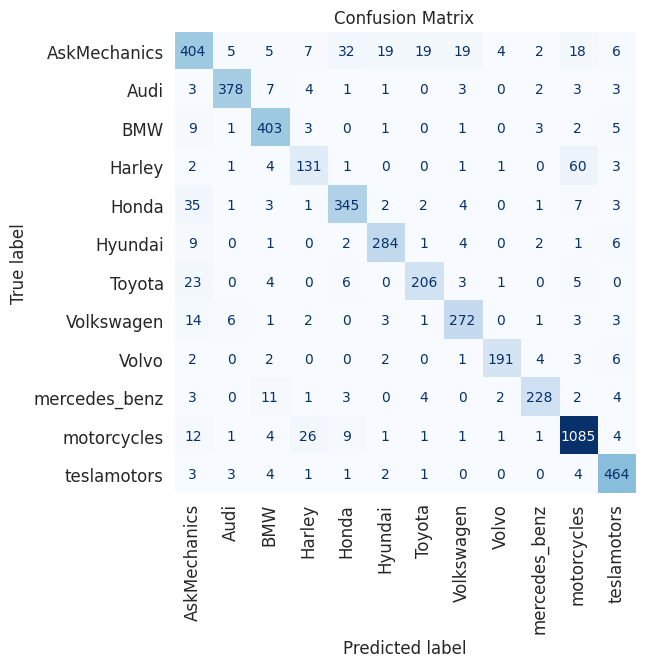

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize=None) # or None
    fig, ax = plt.subplots(figsize=(6, 6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".0f", ax=ax, colorbar=False, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()


# label names - specifies order in confusion matrix
label_names = cl.names

plot_confusion_matrix(y_test, y_test_pred, cl.names)

This was the TF-IDF confusion matrix:
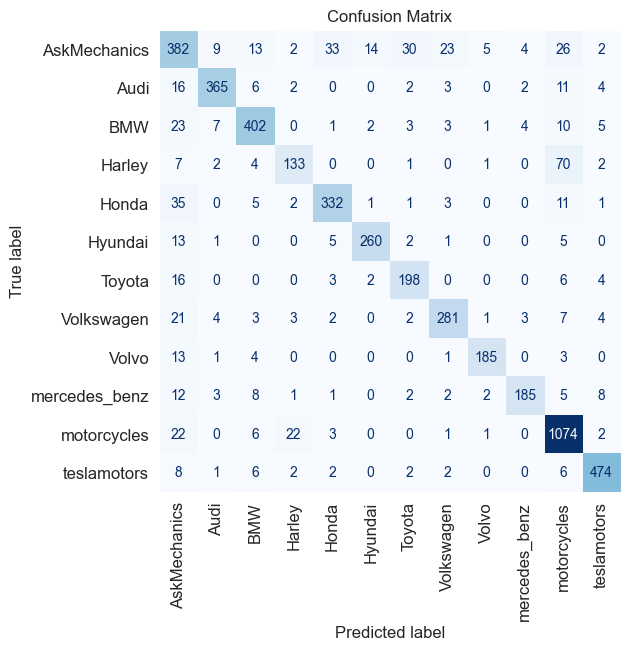

While overall accuracy did not increase very much, we see significant improvements in certain categories.